## Final Notebook

Please fill out:
* Student name: Andrew Levinton
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Ahbineet Kulkarni
* Blog post URL:


## Statsmodels debug
- This is because statsmodels was having version issues. this is a workaround
- The code below re-publishes the existing (but private) _centered function as a public attribute to the module already imported in RAM.

In [90]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

## Import necessary libraries

In [91]:
# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# data visualiztion
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# regression modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")



plt.style.use('ggplot')

## Define Functions

In [92]:

# Grabbing vifs

def get_vifs(data):
    # Get a list of the column names
    cols = data.columns

    # Create an empty DataFrame to hold the VIF results
    vif_data = pd.DataFrame()

    # Loop through each column and calculate the VIF
    for i in range(len(cols)):
        vif = variance_inflation_factor(data[cols].values, i)
        vif_data = vif_data.append({'Variable': cols[i], 'VIF': vif}, ignore_index=True)

    # Print the VIF results
    return print(vif_data)


# get ols model and plot residual distribution
def get_OLS_model(name, X, y):
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    model_residual = results.resid
    
    return print(results.summary()), plt.suptitle(f'Residual distribution for {name} model'), sns.distplot(model_residual), plt.show()



#get qq and histogram plots 
def plot_hist_qq(df, target_col):
    """
    Creates a histogram and QQ-plot for a given dataframe and target column.

    Args:
        df (pandas.DataFrame): The dataframe to plot.
        target_col (str): The name of the target column.

    Returns:
        None
    """
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot histogram on the first subplot
    axs[0].hist(df[target_col], bins=30)
    axs[0].set_xlabel(target_col)
    axs[0].set_ylabel('Frequency')

    # Plot QQ-plot on the second subplot
    stats.probplot(df[target_col], plot=axs[1])
    axs[1].set_xlabel('Theoretical quantiles')
    axs[1].set_ylabel('Sample quantiles')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()
    
# getting qqplots from stats model
def get_model_qqplots(data, y):    
    # Set up the plot grid
    fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25, 18))

    # Loop through each variable in the DataFrame
    for i, var in enumerate(data.columns):
        # Fit a linear regression model
        X = sm.add_constant(data[var])
        model = sm.OLS(y, X).fit()

        # Calculate the residuals
        resid = model.resid

        # Create a QQ plot
        sm.qqplot(resid, line='s', ax=axes[i//6, i%6])
        axes[i//6, i%6].set_title(var)

    plt.tight_layout()
    plt.show()

## Read in dataset, check length

In [93]:
cd data

C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_2\Housing_Linear_Model_Project\data


In [94]:
df = pd.read_csv('kc_house_data.csv')
len(df)

30155

## Dataset timeline

In [95]:
df['yr_built'].min(), df['yr_built'].max()

(1900, 2022)

### Checking dtypes

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

## Linear Model must meet the following assumptions:

### Simple Linear Regression on select features
Assumption check:
- Is it linear?
- Is it normal?
    - histogram
    - QQ-plot
- Is it homoscedastic?

## The process for building this linear model:
- Prep data for linear model regression: This involves dropping null values, dropping "bad data", as well as engineering features to assist in assuming linearization
- Key scores to look at:
- `R-Squared ( or the coefficient of determination)` - a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. In other words, r-squared shows how well the data fit the regression model (the goodness of fit).
- `Correlation coefficients` - check to see what variables seem relatable to the target variable (price)
- `residual plots` - check how far data compares to the mean. Data should be normally distributed to avoid skewness of the mean
- `variance inflation factor` - level of statistical skew
- `Root mean squared erro`r - how far predictions fall from measured true values using Euclidean distance.
- `pvalues of independent variables` - measures how statistically significant the independent variables are

## Data Preparation

## Dropping nullls

In [97]:
df.dropna(inplace=True)

### Recheck length

In [98]:
len(df)

30111

### Looking at Washington state

In [99]:
df['address'] = df['address'].str.lower()

In [100]:
df = df[df['address'].str.contains('washington')]

In [101]:
len(df)

29208

## Grabbing Zipcodes

In [102]:
df['zipcode'] = df['address'].apply(lambda x: x.split(',')[2].split(' ')[-1])

In [103]:
df['zipcode'] = df['zipcode'].astype(str)

In [104]:
df['zipcode'].unique()

array(['98055', '98133', '98178', '98118', '98027', '98166', '98030',
       '98023', '98019', '98144', '98031', '98092', '98103', '98006',
       '98136', '98007', '98038', '98057', '98077', '98126', '98053',
       '98039', '98107', '98008', '98155', '98168', '98199', '98004',
       '98045', '98052', '98011', '98002', '98033', '98116', '98198',
       '98125', '98001', '98112', '98034', '98056', '98059', '98005',
       '98040', '98014', '98106', '98029', '98122', '98003', '98117',
       '98042', '98119', '98065', '98022', '98072', '98058', '98108',
       '98115', '98074', '98105', '98024', '98146', '98109', '98102',
       '98028', '98188', '98177', '98075', '98010', '98148', '98047',
       '98032', '98070', '98051', '98288', '98354', '98272', '98296',
       '98271', '98050', '63090', 'seattle', '98387', '15301', '98251',
       '98223', '98338', '98224', '98372', '98663', '99202', '99403',
       '98422', '99203', '99223', '98270'], dtype=object)

## Categorizing waterfronts

In [105]:
duwamish = ['98168']
elliot_bay_zips= ['98119','98104','98129','98132','98127','98125','98195','98101','98134','98170','98139','98131','98181','98121'] 
puget_sound = ['98071','98083','98013','98070','98031','98131','98063','98195','98207','98190'] 
lake_union = ['98109']
ship_canal = ['00000'] 
lake_washington = ['98072','98077'] 
lake_sammamish = ['98074','98075','98029'] 
other = ['00000']
river_slough_waterfronts = ['00000']

df['waterfront_loc'] = df['zipcode'].apply(lambda x: 'Duwamish' if x=='98168'\
                                          else 'Elliot Bay' if x in elliot_bay_zips\
                                          else 'Puget Sound' if x in puget_sound\
                                          else 'Lake Union' if x in lake_union\
                                          else 'ship canal' if x in ship_canal\
                                          else 'Lake Washington' if x in lake_washington\
                                          else 'Lake Sammamish' if x in lake_sammamish\
                                          else 'other')

In [106]:
df['waterfront_loc'].value_counts()

other              25497
Lake Sammamish      1159
Elliot Bay           730
Puget Sound          721
Lake Washington      589
Duwamish             383
Lake Union           129
Name: waterfront_loc, dtype: int64

## Filter by state of Washington Zipcodes (assuming seattle is its own zipcode)

In [107]:
df = df[df['zipcode'].str.startswith('98') | df['zipcode'].str.contains('seattle')]

## One Hot Encoding Waterfronts

In [108]:
waterfront_dummies = pd.get_dummies(df['waterfront_loc'], prefix='water', drop_first=True)

In [109]:
waterfront_dummies

water_Elliot Bay  water_Lake Sammamish  water_Lake Union  \
0                     0                     0                 0   
1                     0                     0                 0   
2                     0                     0                 0   
3                     0                     0                 0   
4                     0                     0                 0   
...                 ...                   ...               ...   
30150                 0                     0                 0   
30151                 0                     0                 0   
30152                 0                     0                 0   
30153                 0                     0                 0   
30154                 0                     0                 0   

       water_Lake Washington  water_Puget Sound  water_other  
0                          0                  0            1  
1                          0                  0            1  
2                          0                  0            1  
3                          0                  0            1  
4                          0                  0            1  
...                      ...                ...          ...  
30150                      0                  0            1  
30151                      0                  0            1  
30152                      0                  0            1  
30153                      0                  0            1  
30154                      0                  0            1  

[29200 rows x 6 columns]

In [110]:
len(df) 

29200

In [111]:
len(df) == len(waterfront_dummies)

True

In [112]:
df = pd.concat([df,waterfront_dummies], axis=1)

## replacing seattle with seattle zipcode

In [113]:
df['zipcode'] = df['zipcode'].apply(lambda x: '98101' if x=='seattle' else x)

## recheck zipcodes

In [114]:
df['zipcode'].unique()

array(['98055', '98133', '98178', '98118', '98027', '98166', '98030',
       '98023', '98019', '98144', '98031', '98092', '98103', '98006',
       '98136', '98007', '98038', '98057', '98077', '98126', '98053',
       '98039', '98107', '98008', '98155', '98168', '98199', '98004',
       '98045', '98052', '98011', '98002', '98033', '98116', '98198',
       '98125', '98001', '98112', '98034', '98056', '98059', '98005',
       '98040', '98014', '98106', '98029', '98122', '98003', '98117',
       '98042', '98119', '98065', '98022', '98072', '98058', '98108',
       '98115', '98074', '98105', '98024', '98146', '98109', '98102',
       '98028', '98188', '98177', '98075', '98010', '98148', '98047',
       '98032', '98070', '98051', '98288', '98354', '98272', '98296',
       '98271', '98050', '98101', '98387', '98251', '98223', '98338',
       '98224', '98372', '98663', '98422', '98270'], dtype=object)

In [115]:
len(df['zipcode'].unique())

89

## Adding in Engineered Zipcode Data Generated from GreatSchools API

The csv file that is being imported was generated using an extensive process of requests and data aggregation of school ratings by zipcode. To view the process of retrieval and aggregation please visit the file Final_Exploratory_Data_Analysis.ipynb in the notebooks folder.

In [116]:
cd ..

C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_2\Housing_Linear_Model_Project


In [117]:
school_ratings = pd.read_csv('school_ratings_by_zipcode.csv')
school_ratings['zipcode'] = school_ratings['zipcode'].astype(str)

## Assigning average school ratings to corresponding zipcodes

In [118]:
# Create a dictionary from the zipcode dataframe
zip_dict = school_ratings.set_index('zipcode')['avg_rating'].to_dict()

# Load your larger dataframe


# Assign the ratings from the zipcode dictionary to the large dataframe
df['school_rating'] = df['zipcode'].apply(lambda x: zip_dict.get(x, None))

# The above line applies the lambda function to each element of the 'zipcode' column of the large dataframe. 
# If the zipcode is present in the zip_dict, its corresponding rating is assigned to the 'rating' column. 
# If not, None is assigned.

# You can then save the updated large dataframe to a new csv file
df['school_rating'].isnull().sum()

11315

## Filling nulls with mean value

In [119]:
mean_val = df['school_rating'].mean()

In [120]:
df['school_rating'] = df['school_rating'].fillna(mean_val)

In [121]:
df['school_rating'].isnull().sum()

0

## Observing correlation matrix for possible features that can be used with the price

In [122]:
df.corr()['price'].abs().sort_values(ascending=False)

price                    1.000000
sqft_living              0.616741
sqft_above               0.546108
bathrooms                0.488039
sqft_patio               0.317623
lat                      0.296212
bedrooms                 0.290994
sqft_garage              0.267477
school_rating            0.251165
sqft_basement            0.246548
floors                   0.199285
water_Lake Sammamish     0.141426
yr_built                 0.105877
sqft_lot                 0.086790
yr_renovated             0.085506
long                     0.081940
water_Lake Washington    0.070383
water_Puget Sound        0.068457
water_other              0.064781
water_Lake Union         0.035352
id                       0.030237
water_Elliot Bay         0.004859
Name: price, dtype: float64

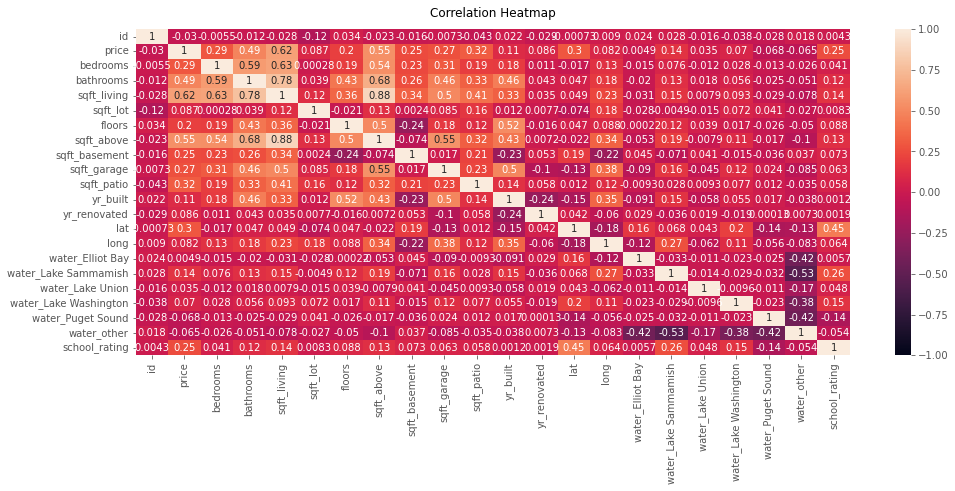

In [123]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


### Observations
- At first glance, it appears that sqft_living, sqft_above and bathrooms are the strongest correlated features to the price. 
- Further investigation is needed to measure the validity of the variables. They may be correlated with the price due to skewness or other factors that can make the correlation a deceptively "good" feature.
- To investigate further, we will monitor the Variance Inflation Factor(VIF) to address the issue of multicollinearity.

## Changing categorical variables to numerical columns - this needs to be done if we want to use them in a linear model

In [124]:
#extracting grade as an integer
df['grade'] = df['grade'].apply(lambda x: int(str(x.split(' ')[0])))

# replacing conditions with values
cond_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
df.condition.replace(to_replace=cond_dict,inplace=True)

#changing date to datetime object, get day and month
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

df['day_of_year'] = df['date'].dt.dayofyear

## Recheck dtypes

In [125]:
df.dtypes

id                                int64
date                     datetime64[ns]
price                           float64
bedrooms                          int64
bathrooms                       float64
sqft_living                       int64
sqft_lot                          int64
floors                          float64
waterfront                       object
greenbelt                        object
nuisance                         object
view                             object
condition                         int64
grade                             int64
heat_source                      object
sewer_system                     object
sqft_above                        int64
sqft_basement                     int64
sqft_garage                       int64
sqft_patio                        int64
yr_built                          int64
yr_renovated                      int64
address                          object
lat                             float64
long                            float64


### Extracting Numerical Predictors by filtering dtypes

In [126]:
df.dtypes.unique()

array([dtype('int64'), dtype('<M8[ns]'), dtype('float64'), dtype('O'),
       dtype('uint8')], dtype=object)

In [127]:
# categorizing dtypes
numerical_types = ['int64','float64']
numerical_predictors = list(df.select_dtypes(include=numerical_types))
numerical_predictors

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'school_rating',
 'month',
 'day_of_year']

### Create dataframe of numerical values

In [128]:
# df[numerical_predictors] selects only numerical columns
df_numerical = df[numerical_predictors]

In [129]:
df_numerical.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'sqft_garage', 'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'school_rating', 'month', 'day_of_year'],
      dtype='object')

In [130]:
len(df_numerical)

29200

In [131]:
len(waterfront_dummies)

29200

## Dropping price to isolate predictors

In [132]:
df_numerical = df_numerical.drop(['id','price'],axis=1)

In [133]:
df_numerical['floors'] = df['floors'].astype(float)

### Calculating variance inflation factor [VIF]

#### VIF levels:

- Good: VIF <= 5

- Moderate/Questionable: VIF >=5 and VIF <= 10

- Throw out: VIF >= 10


In [134]:
print(get_vifs(df_numerical))

         Variable            VIF
0        bedrooms      24.768622
1       bathrooms      26.263735
2     sqft_living     119.808110
3        sqft_lot       1.140594
4          floors      17.177547
5       condition      31.150197
6           grade     133.035571
7      sqft_above      92.874304
8   sqft_basement       7.075288
9     sqft_garage       4.675596
10     sqft_patio       2.240790
11       yr_built    9263.218882
12   yr_renovated       1.211647
13            lat  136585.268881
14           long  146658.438892
15  school_rating      22.635104
16          month     697.233857
17    day_of_year     612.219197
None


### It appears at first glance that the data only yields a small set of independent variables that are not highly collinear with eachother. This will be looked at again after the removal of outliers, and the transformation of data. 

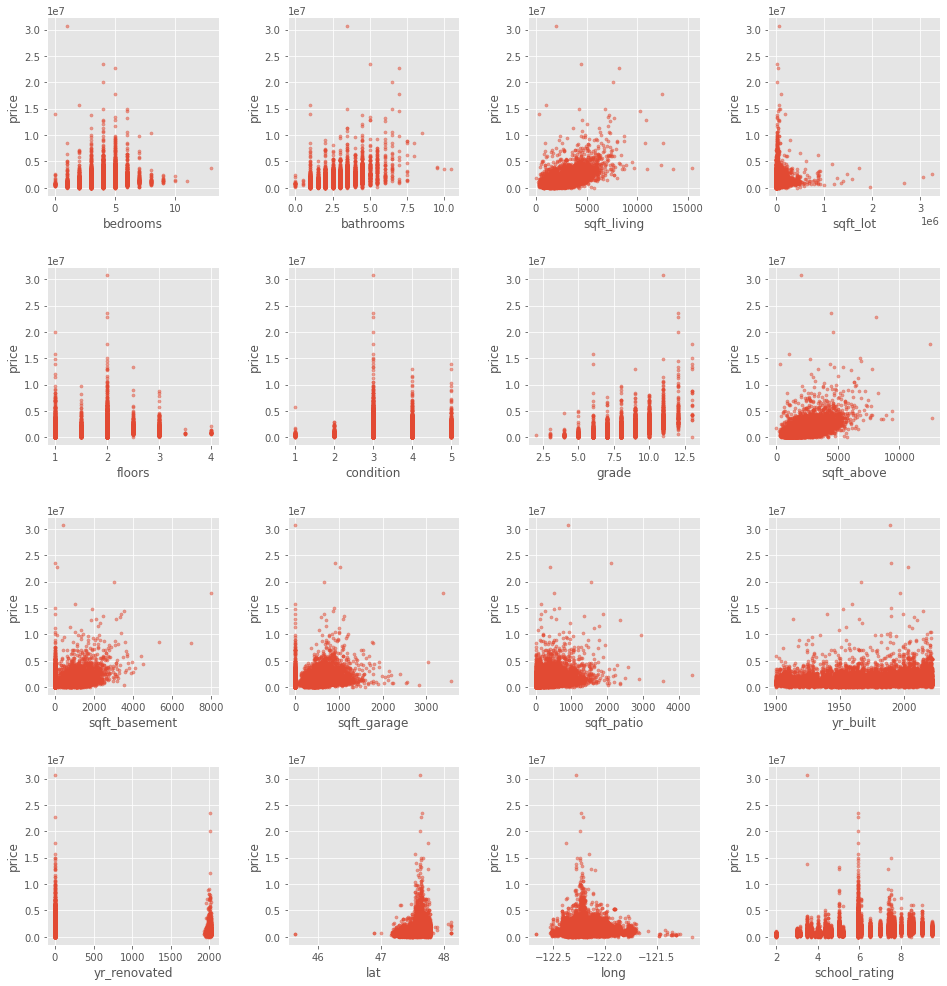

In [135]:
# Specify the dependent variable and independent variables
y_col = 'price'
x_cols = [col for col in df_numerical.columns if col != y_col][:16]  # Use the first 15 independent variables

# Create scatter plot matrix
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, x_var in enumerate(x_cols):
    row, col = divmod(i, 4)
    axs[row, col].scatter(df_numerical[x_var], df[y_col], alpha=0.5, s=10)
    axs[row, col].set_xlabel(x_var)
    axs[row, col].set_ylabel(y_col)

# Adjust plot layout
fig.subplots_adjust(top=0.93, hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

### Extracting Categorical String Predictors

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29200 entries, 0 to 30154
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     29200 non-null  int64         
 1   date                   29200 non-null  datetime64[ns]
 2   price                  29200 non-null  float64       
 3   bedrooms               29200 non-null  int64         
 4   bathrooms              29200 non-null  float64       
 5   sqft_living            29200 non-null  int64         
 6   sqft_lot               29200 non-null  int64         
 7   floors                 29200 non-null  float64       
 8   waterfront             29200 non-null  object        
 9   greenbelt              29200 non-null  object        
 10  nuisance               29200 non-null  object        
 11  view                   29200 non-null  object        
 12  condition              29200 non-null  int64         
 13  g

In [137]:
categorical_types = ['O']
categorical_predictors = list(df.select_dtypes(include=categorical_types))
categorical_predictors

['waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'heat_source',
 'sewer_system',
 'address',
 'zipcode',
 'waterfront_loc']

In [138]:
df_categorical = df[categorical_predictors]

In [139]:
df_categorical

waterfront greenbelt nuisance     view  heat_source sewer_system  \
0             NO        NO       NO     NONE          Gas       PUBLIC   
1             NO        NO      YES  AVERAGE          Oil       PUBLIC   
2             NO        NO       NO  AVERAGE          Gas       PUBLIC   
3             NO        NO       NO  AVERAGE          Gas       PUBLIC   
4             NO        NO      YES     NONE  Electricity       PUBLIC   
...          ...       ...      ...      ...          ...          ...   
30150         NO        NO       NO     NONE          Oil       PUBLIC   
30151         NO        NO       NO     FAIR          Gas       PUBLIC   
30152         NO        NO      YES     NONE          Gas       PUBLIC   
30153         NO        NO       NO     NONE          Gas       PUBLIC   
30154         NO        NO       NO     NONE          Oil       PUBLIC   

                                                 address zipcode  \
0      2102 southeast 21st court, renton, washington ...   98055   
1      11231 greenwood avenue north, seattle, washing...   98133   
2      8504 south 113th street, seattle, washington 9...   98178   
3      4079 letitia avenue south, seattle, washington...   98118   
4      2193 northwest talus drive, issaquah, washingt...   98027   
...                                                  ...     ...   
30150  4673 eastern avenue north, seattle, washington...   98103   
30151  4131 44th avenue southwest, seattle, washingto...   98116   
30152  910 martin luther king jr way, seattle, washin...   98122   
30153  17127 114th avenue southeast, renton, washingt...   98055   
30154  18615 7th avenue south, burien, washington 981...   98148   

      waterfront_loc  
0              other  
1              other  
2              other  
3              other  
4              other  
...              ...  
30150          other  
30151          other  
30152          other  
30153          other  
30154          other  

[29200 rows x 9 columns]

# Model #1

In [140]:
model_data = df_numerical

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     1720.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:41:56   Log-Likelihood:            -4.3106e+05
No. Observations:               29200   AIC:                         8.622e+05
Df Residuals:                   29181   BIC:                         8.623e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -6.06e+07      4e+06    -15.154

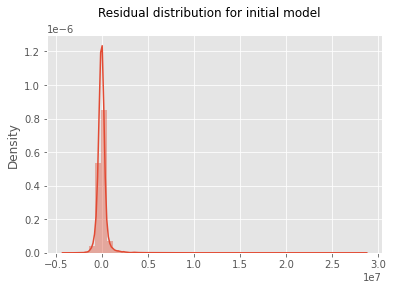

(None,
 Text(0.5, 0.98, 'Residual distribution for initial model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [141]:
get_OLS_model('initial',X = model_data, y = df['price'])

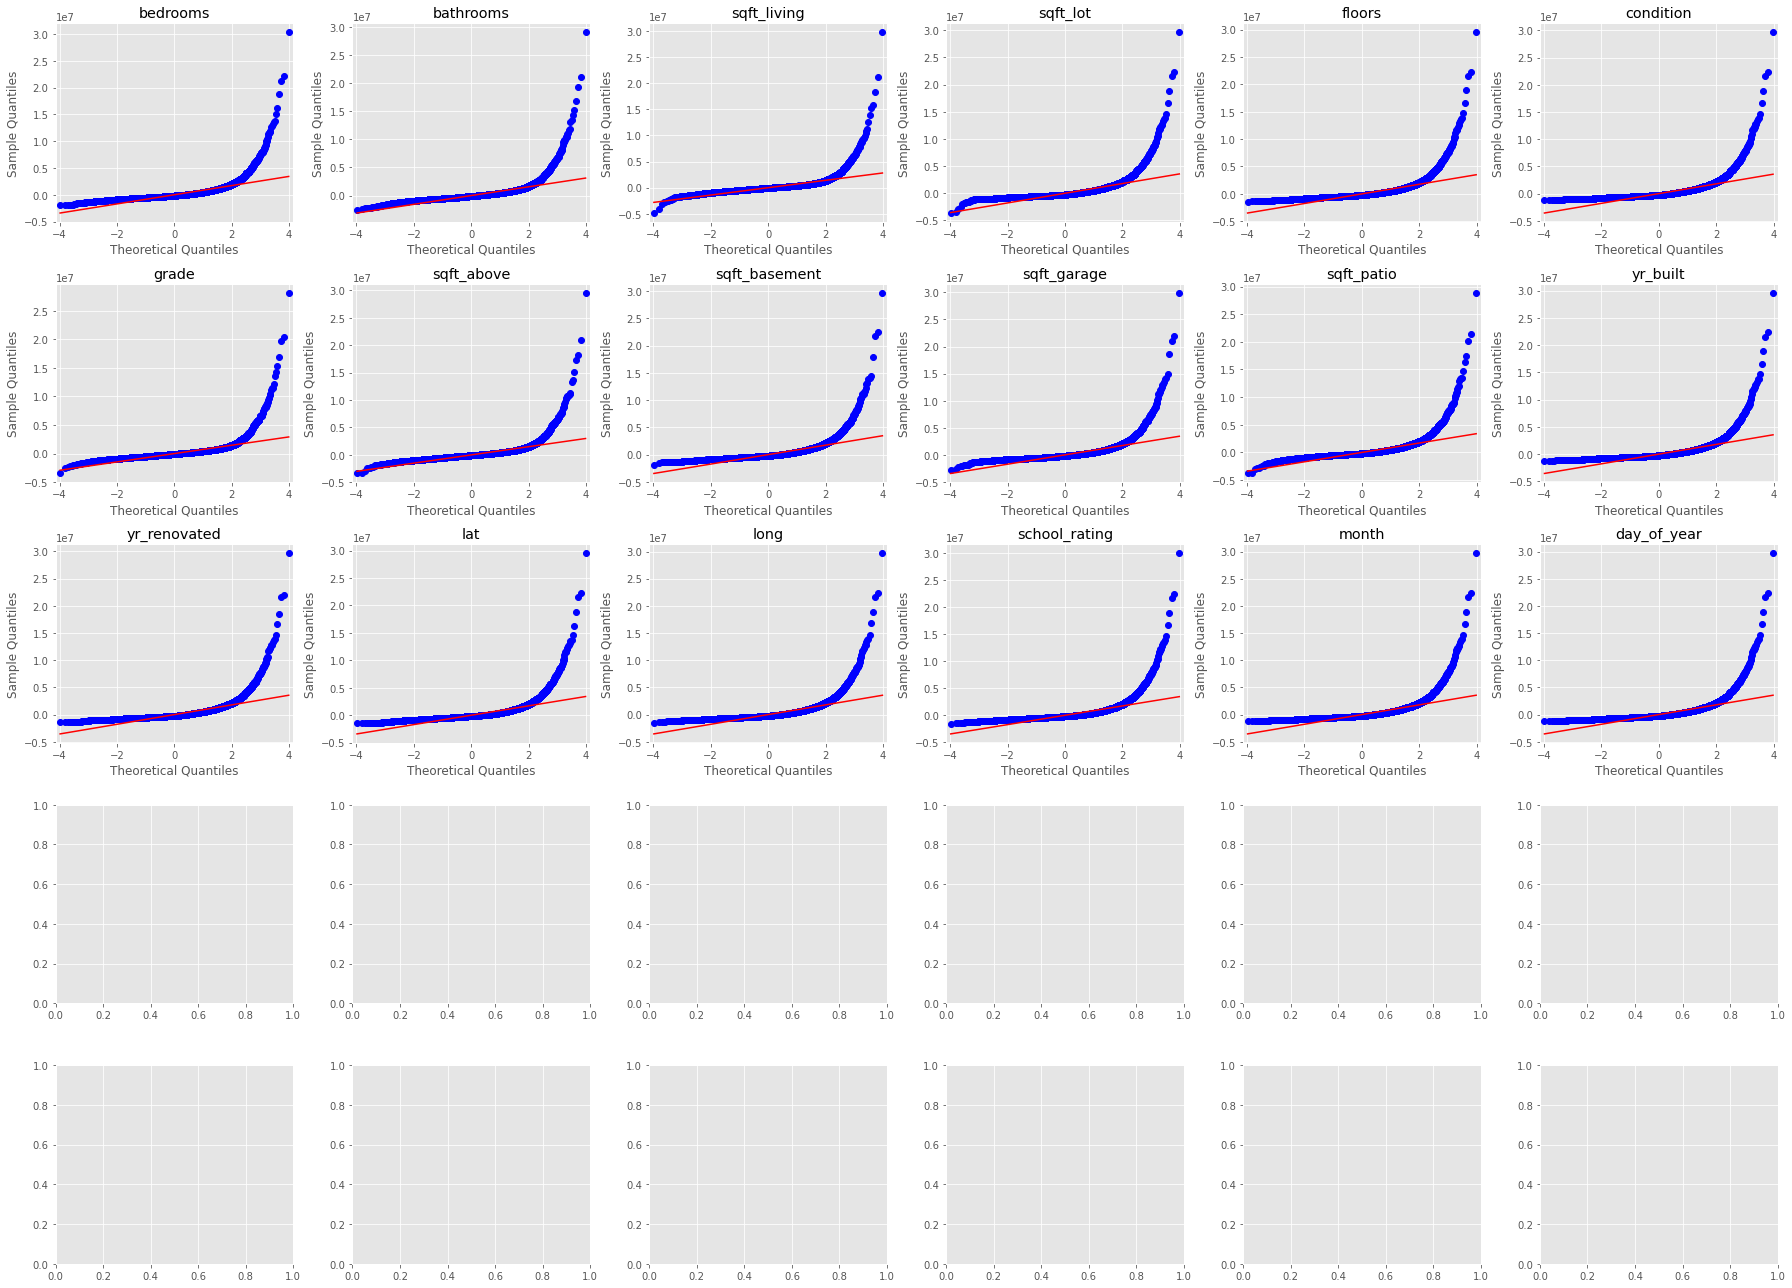

In [142]:
get_model_qqplots(model_data, df['price'])

# Observations

p_value > 0.05

- `longitude`**
- `month`

 - month was not anticipated as an effective predictor because it is not typical for the season to affect the sale price of a house
 
 Additional Observations:
 - The adjusted r-squared value is .514, indicating that his model can explain approximately 51.4% of the data.
 -  Skew: A kurtosis value between -2 and +2 is good to prove normalcy. The skew score is 10.065, indicating that this model is heavily skewed. This will be addressed through transformations to normalize the data. 

## Possible Improvements to be made to model:
    - dropping of variables that are not statistically significant (Pval > 0.05)
    - addition of categorial variables(one hot encoded)
    - location would possibly be the most interesting variable, mapped against the waterfront or view variable
    - transformation of data to satisfy normality assumption -ex: log transformation or square root transformation
    - removal of outliers: Outliers in this case will be considered to be any data falling greater than 
      3 standard deviations outside the mean
### Goals
    - improve skewness - removal of outliers, transform data
    - improve on homoscedasticity
    - increase rsquared to promote higher level explanation of data from model
    - remove collinearity - all VIFs less than a value of 5. 

# Categorical data Exploratory Analysis and Engineering

The goal of this section will be to add in meaningful categorical data to the model, to be OneHotEncoded once prepped. For this, we first look at the categorical data. 

In [143]:
df_categorical.columns

Index(['waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source',
       'sewer_system', 'address', 'zipcode', 'waterfront_loc'],
      dtype='object')

## Possible categorical variables of interest: 

* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `address` - The street address

The grade and condition are already onehotencoded in the model and could be changed to a numerical variable, so this part of the analysis will focus on the string categorical variables. 

The address appears to be the most interesting variable in the batch because it can be mapped against the waterfronts or the quality of view from the houses. For this, we will extrapolate features of the address to reduce and categorize the location. 

In [144]:
df['waterfront'].unique()

array(['NO', 'YES'], dtype=object)

In [145]:
# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)

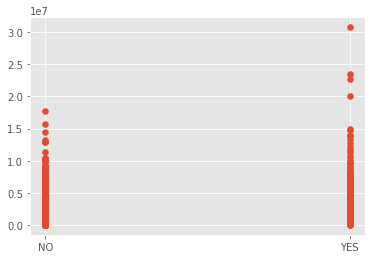

In [146]:
plt.scatter(x=df['waterfront'], y=df['price'])

In [147]:
df['nuisance'].unique()

array(['NO', 'YES'], dtype=object)

In [148]:
# convert nuisance into numeric boolean
nuisance_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.nuisance.replace(to_replace=nuisance_bool_dict,inplace=True)

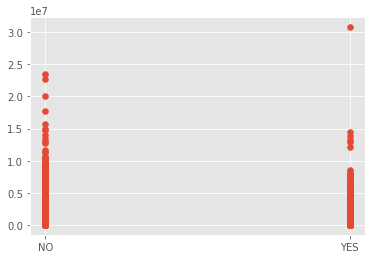

In [149]:
plt.scatter(x=df['nuisance'], y=df['price'])

In [150]:
# convert nuisance into numeric boolean
greenbelt_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.greenbelt.replace(to_replace=greenbelt_bool_dict,inplace=True)

In [151]:
df['view'].unique()

array(['NONE', 'AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD'], dtype=object)

In [152]:
# convert view from string into categorical ordinal
view_dict = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
df_categorical.view.replace(to_replace=view_dict,inplace=True)

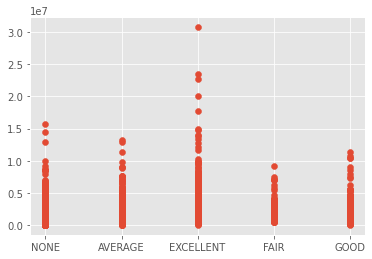

In [153]:
plt.scatter(x=df['view'], y=df['price'])

In [154]:
df['heat_source'].unique()

array(['Gas', 'Oil', 'Electricity', 'Gas/Solar', 'Electricity/Solar',
       'Other', 'Oil/Solar'], dtype=object)

In [155]:
heat_source_dummies = pd.get_dummies(df['heat_source'], prefix='heat_source',drop_first=True)
heat_source_dummies

heat_source_Electricity/Solar  heat_source_Gas  heat_source_Gas/Solar  \
0                                  0                1                      0   
1                                  0                0                      0   
2                                  0                1                      0   
3                                  0                1                      0   
4                                  0                0                      0   
...                              ...              ...                    ...   
30150                              0                0                      0   
30151                              0                1                      0   
30152                              0                1                      0   
30153                              0                1                      0   
30154                              0                0                      0   

       heat_source_Oil  heat_source_Oil/Solar  heat_source_Other  
0                    0                      0                  0  
1                    1                      0                  0  
2                    0                      0                  0  
3                    0                      0                  0  
4                    0                      0                  0  
...                ...                    ...                ...  
30150                1                      0                  0  
30151                0                      0                  0  
30152                0                      0                  0  
30153                0                      0                  0  
30154                1                      0                  0  

[29200 rows x 6 columns]

In [156]:
df['sewer_system'].unique()

array(['PUBLIC', 'PRIVATE', 'PRIVATE RESTRICTED', 'PUBLIC RESTRICTED'],
      dtype=object)

In [157]:
sewer_dummies = pd.get_dummies(df['sewer_system'],prefix='sewer', drop_first=True)
sewer_dummies

sewer_PRIVATE RESTRICTED  sewer_PUBLIC  sewer_PUBLIC RESTRICTED
0                             0             1                        0
1                             0             1                        0
2                             0             1                        0
3                             0             1                        0
4                             0             1                        0
...                         ...           ...                      ...
30150                         0             1                        0
30151                         0             1                        0
30152                         0             1                        0
30153                         0             1                        0
30154                         0             1                        0

[29200 rows x 3 columns]

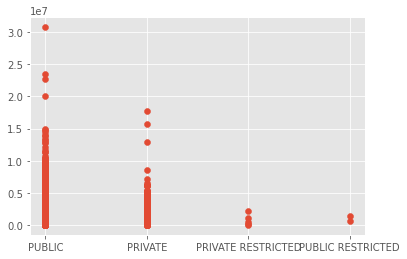

In [158]:
plt.scatter(x=df['sewer_system'], y=df['price'])

### Developing categorical dataframe

In [159]:
df_cat_pick = df_categorical[['waterfront','nuisance','view','greenbelt']]

## Model #2

In [160]:
model_2_data = pd.concat([df_numerical,sewer_dummies,heat_source_dummies, df_cat_pick], axis = 1)

In [161]:
len(model_2_data) == len(waterfront_dummies)

True

In [162]:
model_2_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_garage',
       'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'school_rating', 'month', 'day_of_year', 'sewer_PRIVATE RESTRICTED',
       'sewer_PUBLIC', 'sewer_PUBLIC RESTRICTED',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'waterfront', 'nuisance', 'view', 'greenbelt'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     1177.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:42:05   Log-Likelihood:            -4.2978e+05
No. Observations:               29200   AIC:                         8.596e+05
Df Residuals:                   29168   BIC:                         8.599e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

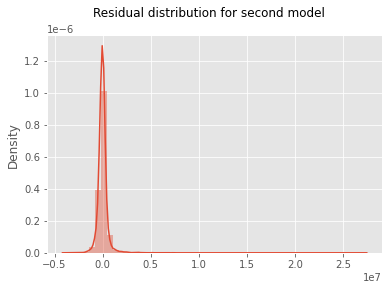

(None,
 Text(0.5, 0.98, 'Residual distribution for second model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [163]:
get_OLS_model('second',model_2_data, df['price'])

`heat_source`, `greenbelt` and `sewer_system` both have incredibly high p-values. These will be dropped from the final model if it holds. 

## Observations of Model 2

Model is still highly skewed although did present itself with some improvements. Next steps will be to normalize the data by transforming features that are skewed within the data, as well as remove outliers

- Jarque-Bera score is sky high and must come down for the model to hold any validity. 
- Durbin Watson score is in the acceptable range of 1.50-2.50
- Rsquared has 'improved' but only at the expense of the the continued flaws mentioned before. 

## Eliminating Outliers

To normalize the distribution, outlier removal will be the first step. An outlier will be defined as three standard deviations away from the mean of the target variable.

In [164]:
outlier_thresh = df['price'].std()*3 # value of the prices at the third standard deviation
df_outlier_removed = df.loc[abs(df['price']) <= outlier_thresh] # slicing all data within the defined range

# assign y as the target variable
y = df_outlier_removed['price']

In [165]:
model_2_data_outlier_removed = model_2_data.loc[abs(df['price']) <= outlier_thresh]

In [166]:
df_outlier_removed

id       date      price  bedrooms  bathrooms  sqft_living  \
0      7399300360 2022-05-24   675000.0         4        1.0         1180   
1      8910500230 2021-12-13   920000.0         5        2.5         2770   
2      1180000275 2021-09-29   311000.0         6        2.0         2880   
3      1604601802 2021-12-14   775000.0         3        3.0         2160   
4      8562780790 2021-08-24   592500.0         2        2.0         1120   
...           ...        ...        ...       ...        ...          ...   
30150  7834800180 2021-11-30  1555000.0         5        2.0         1910   
30151   194000695 2021-06-16  1313000.0         3        2.0         2020   
30152  7960100080 2022-05-27   800000.0         3        2.0         1620   
30153  2781280080 2022-02-24   775000.0         3        2.5         2570   
30154  9557800100 2022-04-29   500000.0         3        1.5         1200   

       sqft_lot  floors waterfront greenbelt  ... waterfront_loc  \
0          7140     1.0         NO        NO  ...          other   
1          6703     1.0         NO        NO  ...          other   
2          6156     1.0         NO        NO  ...          other   
3          1400     2.0         NO        NO  ...          other   
4           758     2.0         NO        NO  ...          other   
...         ...     ...        ...       ...  ...            ...   
30150      4000     1.5         NO        NO  ...          other   
30151      5800     2.0         NO        NO  ...          other   
30152      3600     1.0         NO        NO  ...          other   
30153      2889     2.0         NO        NO  ...          other   
30154     11058     1.0         NO        NO  ...          other   

      water_Elliot Bay  water_Lake Sammamish  water_Lake Union  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   
...                ...                   ...               ...   
30150                0                     0                 0   
30151                0                     0                 0   
30152                0                     0                 0   
30153                0                     0                 0   
30154                0                     0                 0   

      water_Lake Washington water_Puget Sound  water_other  school_rating  \
0                         0                 0            1       5.937719   
1                         0                 0            1       6.500000   
2                         0                 0            1       4.500000   
3                         0                 0            1       4.000000   
4                         0                 0            1       5.937719   
...                     ...               ...          ...            ...   
30150                     0                 0            1       6.500000   
30151                     0                 0            1       7.666667   
30152                     0                 0            1       3.500000   
30153                     0                 0            1       5.937719   
30154                     0                 0            1       3.500000   

       month  day_of_year  
0          5          144  
1         12          347  
2          9          272  
3         12          348  
4          8          236  
...      ...          ...  
30150     11          334  
30151      6          167  
30152      5          147  
30153      2           55  
30154      4          119  

[28004 rows x 36 columns]

In [167]:
waterfront_dummies = df_outlier_removed[['water_Elliot Bay','water_Lake Sammamish', 'water_Lake Washington','water_Puget Sound','water_other']]

In [168]:
df_outlier_removed.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'zipcode', 'waterfront_loc',
       'water_Elliot Bay', 'water_Lake Sammamish', 'water_Lake Union',
       'water_Lake Washington', 'water_Puget Sound', 'water_other',
       'school_rating', 'month', 'day_of_year'],
      dtype='object')

## New look at model with removed outliers

In [169]:
outlier_data = pd.concat([y,model_2_data_outlier_removed], axis=1)

In [170]:
outlier_data = outlier_data.drop('price', axis=1)

In [171]:
len(outlier_data)

28004

In [172]:
outlier_data

bedrooms  bathrooms  sqft_living  sqft_lot  floors  condition  grade  \
0             4        1.0         1180      7140     1.0          4      7   
1             5        2.5         2770      6703     1.0          3      7   
2             6        2.0         2880      6156     1.0          3      7   
3             3        3.0         2160      1400     2.0          3      9   
4             2        2.0         1120       758     2.0          3      7   
...         ...        ...          ...       ...     ...        ...    ...   
30150         5        2.0         1910      4000     1.5          4      8   
30151         3        2.0         2020      5800     2.0          3      7   
30152         3        2.0         1620      3600     1.0          3      7   
30153         3        2.5         2570      2889     2.0          3      8   
30154         3        1.5         1200     11058     1.0          3      7   

       sqft_above  sqft_basement  sqft_garage  ...  \
0            1180              0            0  ...   
1            1570           1570            0  ...   
2            1580           1580            0  ...   
3            1090           1070          200  ...   
4            1120            550          550  ...   
...           ...            ...          ...  ...   
30150        1600           1130            0  ...   
30151        2020              0            0  ...   
30152         940            920          240  ...   
30153        1830            740          480  ...   
30154        1200              0          420  ...   

       heat_source_Electricity/Solar  heat_source_Gas  heat_source_Gas/Solar  \
0                                  0                1                      0   
1                                  0                0                      0   
2                                  0                1                      0   
3                                  0                1                      0   
4                                  0                0                      0   
...                              ...              ...                    ...   
30150                              0                0                      0   
30151                              0                1                      0   
30152                              0                1                      0   
30153                              0                1                      0   
30154                              0                0                      0   

       heat_source_Oil  heat_source_Oil/Solar  heat_source_Other  waterfront  \
0                    0                      0                  0           0   
1                    1                      0                  0           0   
2                    0                      0                  0           0   
3                    0                      0                  0           0   
4                    0                      0                  0           0   
...                ...                    ...                ...         ...   
30150                1                      0                  0           0   
30151                0                      0                  0           0   
30152                0                      0                  0           0   
30153                0                      0                  0           0   
30154                1                      0                  0           0   

       nuisance  view  greenbelt  
0             0     0          0  
1             1     2          0  
2             0     2          0  
3             0     2          0  
4             1     0          0  
...         ...   ...        ...  
30150         0     0          0  
30151         0     1          0  
30152         1     0          0  
30153         0     0          0  
30154         0     0          0  

[28004 rows x 31 columns]

## Model #3

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1559.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:42:15   Log-Likelihood:            -3.9305e+05
No. Observations:               28004   AIC:                         7.862e+05
Df Residuals:                   27972   BIC:                         7.864e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

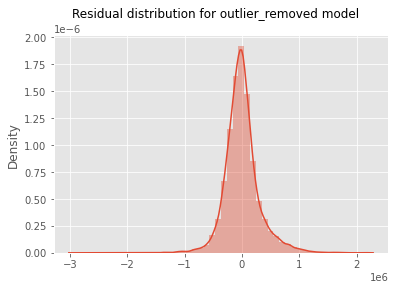

(None,
 Text(0.5, 0.98, 'Residual distribution for outlier_removed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [173]:
get_OLS_model('outlier_removed', outlier_data,y)

In [174]:
outlier_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_garage',
       'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'school_rating', 'month', 'day_of_year', 'sewer_PRIVATE RESTRICTED',
       'sewer_PUBLIC', 'sewer_PUBLIC RESTRICTED',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'waterfront', 'nuisance', 'view', 'greenbelt'],
      dtype='object')

## Observations of model 3
pvalue > 0.05
- `sqft_basement` 
- `sqft_garage`
- `sewer_PRIVATE RESTRICTED`
- `sewer_PUBLIC RESTRICTED`
- `heat_source_Electricity/Solar`
- `heat_source_Oil/Solar`
- `heat_source_Other`



- Adjusted rsquared indicates that the model explains 62.2% of the data.
- Skewness has improved dramatically to an acceptable range between -2 and 2. The removal of outliers has made this possible.
- Durbin-Watson score is still in the acceptable ranges of 1.5-2.5
- Jarque-Bera score is still very high but has been brought down by a significant factor. Still not perfect but trending in the right direction.
- Multicollinearity is possibly present in the model and likely so given the initial VIFs before the first model was built. VIFS should be revisited again to see if those variables are worth keeping. 

## Looking at transformations for the price.

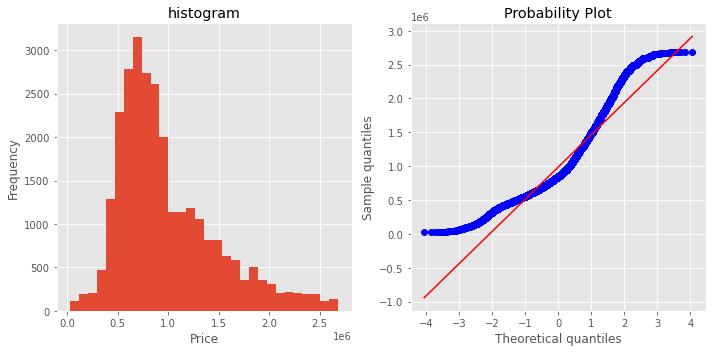

In [175]:
import scipy.stats as stats
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram on the first subplot
axs[0].hist(y, bins=30)
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')
axs[0].set_title('histogram')
# Plot QQ-plot on the second subplot
stats.probplot(y, plot=axs[1])
axs[1].set_xlabel('Theoretical quantiles')
axs[1].set_ylabel('Sample quantiles')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### Issue above is the data shows linearization everywhere but both tails of the data. Catching the lower tail will be the goal for the next test of transformation. For this, we will try a root transformation. 

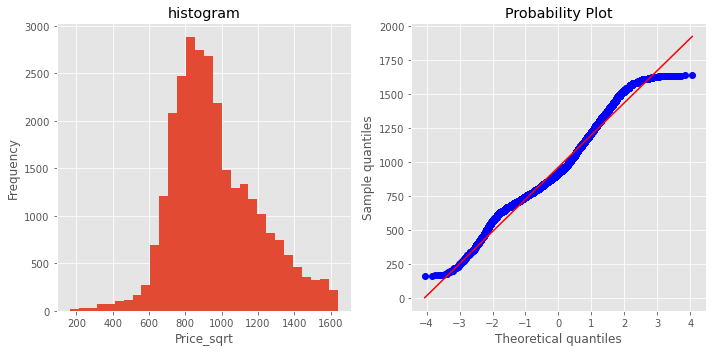

In [176]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
y_sqrt = y**0.5
# Plot histogram on the first subplot
axs[0].hist(y_sqrt, bins=30)
axs[0].set_xlabel('Price_sqrt')
axs[0].set_ylabel('Frequency')
axs[0].set_title('histogram')

# Plot QQ-plot on the second subplot
stats.probplot(y_sqrt, plot=axs[1])
axs[1].set_xlabel('Theoretical quantiles')
axs[1].set_ylabel('Sample quantiles')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

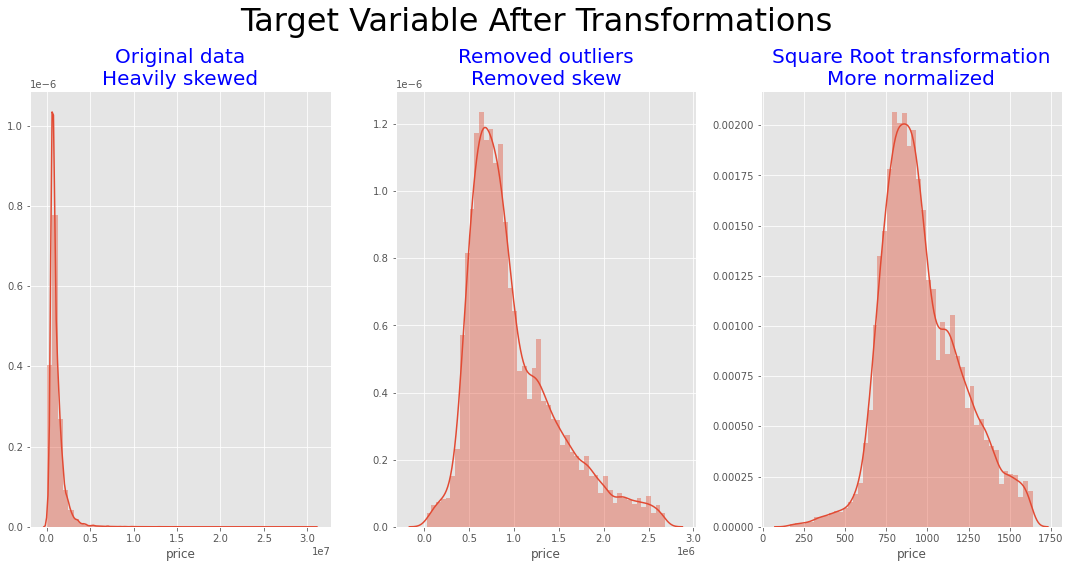

In [177]:
def plot_dist(ax, data, title):
    sns.distplot(data, ax=ax)
    ax.set_title(title, fontsize=20, color='b')
    ax.set_ylabel("")

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Plot the original data
plot_dist(ax1, df['price'], "Original data\nHeavily skewed")


# Plot the data with outliers removed
plot_dist(ax2, y, "Removed outliers\nRemoved skew")

# Apply square root transformation to the data
y_sqrt = np.sqrt(y)

# Plot the transformed data
plot_dist(ax3, y_sqrt, "Square Root transformation\nMore normalized")

# Set the overall title of the figure
fig.suptitle("Target Variable After Transformations", fontsize=32)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the figure
plt.show()


### Checking model with transformed target variable - square root transformation

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     1605.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:27:23   Log-Likelihood:            -1.7892e+05
No. Observations:               28004   AIC:                         3.579e+05
Df Residuals:                   27972   BIC:                         3.582e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

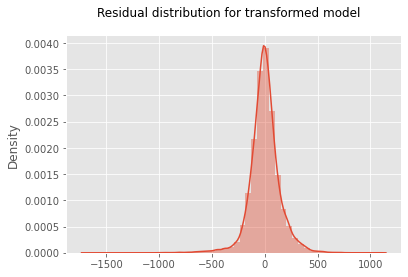

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [146]:
get_OLS_model('transformed', outlier_data, y_sqrt)

## y_log vs y_sqrt

The model with the square root transformation appears to be less skewed and possesses a higher rsquared value, lending the ability of the model to explain more of the data. For these reasons we will use y_sqrt as our dependent variable for now until y_log appears to outweight the benefit of y_sqrt.

Jarque-Beras score is significantly better as well with the y_sqrt variable so I'll go with it for now. 

## Checking distribution of predictor

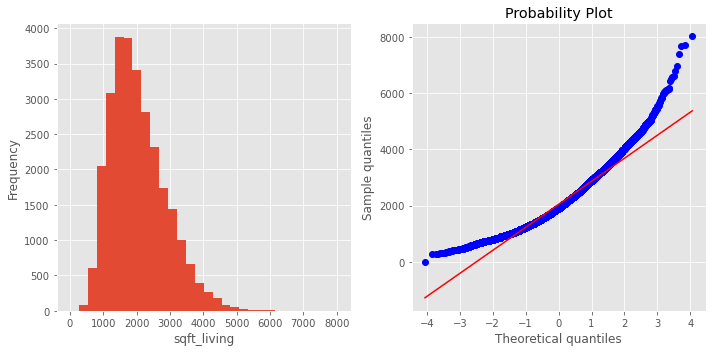

In [147]:
plot_hist_qq(outlier_data, 'sqft_living')

Data is clearly skewed right and follows an exponential pattern similar to price. For this, we will use a logarithmic transformation.

In [148]:
outlier_data['sqft_living_log'] = np.log(outlier_data['sqft_living']) 

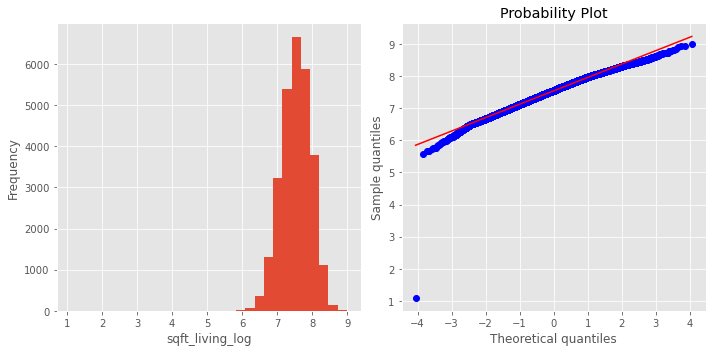

In [149]:
plot_hist_qq(outlier_data, 'sqft_living_log')

In [150]:
outlier_data = outlier_data.drop('sqft_living', axis=1)

In [151]:
outlier_data

bedrooms  bathrooms  sqft_lot  floors  condition  grade  sqft_above  \
0             4        1.0      7140     1.0          4      7        1180   
1             5        2.5      6703     1.0          3      7        1570   
2             6        2.0      6156     1.0          3      7        1580   
3             3        3.0      1400     2.0          3      9        1090   
4             2        2.0       758     2.0          3      7        1120   
...         ...        ...       ...     ...        ...    ...         ...   
30150         5        2.0      4000     1.5          4      8        1600   
30151         3        2.0      5800     2.0          3      7        2020   
30152         3        2.0      3600     1.0          3      7         940   
30153         3        2.5      2889     2.0          3      8        1830   
30154         3        1.5     11058     1.0          3      7        1200   

       sqft_basement  sqft_garage  sqft_patio  ...  heat_source_Gas  \
0                  0            0          40  ...                1   
1               1570            0         240  ...                0   
2               1580            0           0  ...                1   
3               1070          200         270  ...                1   
4                550          550          30  ...                0   
...              ...          ...         ...  ...              ...   
30150           1130            0         210  ...                0   
30151              0            0         520  ...                1   
30152            920          240         110  ...                1   
30153            740          480         100  ...                1   
30154              0          420           0  ...                0   

       heat_source_Gas/Solar  heat_source_Oil  heat_source_Oil/Solar  \
0                          0                0                      0   
1                          0                1                      0   
2                          0                0                      0   
3                          0                0                      0   
4                          0                0                      0   
...                      ...              ...                    ...   
30150                      0                1                      0   
30151                      0                0                      0   
30152                      0                0                      0   
30153                      0                0                      0   
30154                      0                1                      0   

       heat_source_Other  waterfront  nuisance  view  greenbelt  \
0                      0           0         0     0          0   
1                      0           0         1     2          0   
2                      0           0         0     2          0   
3                      0           0         0     2          0   
4                      0           0         1     0          0   
...                  ...         ...       ...   ...        ...   
30150                  0           0         0     0          0   
30151                  0           0         0     1          0   
30152                  0           0         1     0          0   
30153                  0           0         0     0          0   
30154                  0           0         0     0          0   

       sqft_living_log  
0             7.073270  
1             7.926603  
2             7.965546  
3             7.677864  
4             7.021084  
...                ...  
30150         7.554859  
30151         7.610853  
30152         7.390181  
30153         7.851661  
30154         7.090077  

[28004 rows x 31 columns]

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     1591.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:29:11   Log-Likelihood:            -1.7900e+05
No. Observations:               28004   AIC:                         3.581e+05
Df Residuals:                   27972   BIC:                         3.583e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

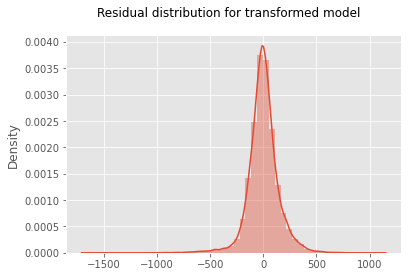

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [152]:
get_OLS_model('transformed', outlier_data, y_sqrt)

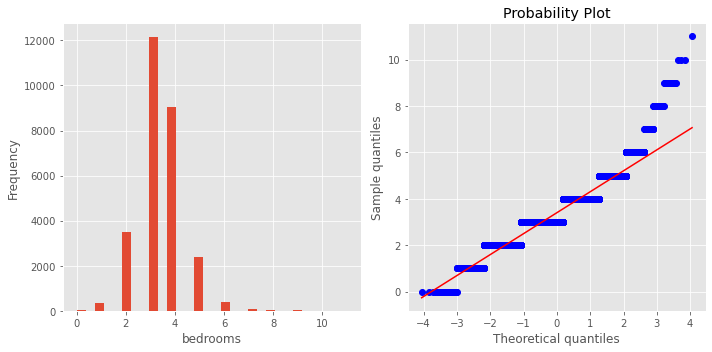

In [153]:
plot_hist_qq(outlier_data, 'bedrooms')

pval > 0.05

- `bedrooms` - will be dropped from the current model


In [154]:
outlier_data = outlier_data.drop(['bedrooms'], axis=1)

#### Rerun model

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     1644.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:29:33   Log-Likelihood:            -1.7900e+05
No. Observations:               28004   AIC:                         3.581e+05
Df Residuals:                   27973   BIC:                         3.583e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

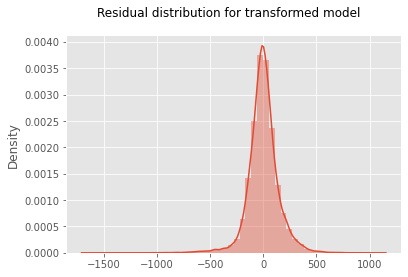

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [155]:
get_OLS_model('transformed', outlier_data, y_sqrt)

### Dropping sewer/heat source data

In [156]:
new_outlier_data = outlier_data.drop(['sewer_PRIVATE RESTRICTED','sewer_PUBLIC RESTRICTED', 'heat_source_Oil', 'heat_source_Oil/Solar', 'heat_source_Other', 'heat_source_Electricity/Solar'], axis =1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     2055.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:29:42   Log-Likelihood:            -1.7901e+05
No. Observations:               28004   AIC:                         3.581e+05
Df Residuals:                   27979   BIC:                         3.583e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -1.35e+

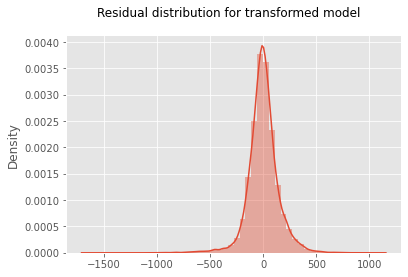

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [157]:
get_OLS_model('transformed', new_outlier_data, y_sqrt)

## Observations

- pval > 0.05

`bedrooms` - dropped from the current model

- all variables are statistically significant (pvalue < 0.05)
- Durbin-Watson Score continues to be "fine" but not improve a whole lot.
- Jarque-Bera Score continues to improve but still must come down
- skewness is now an afterthought as its at a very low -0.347
Overall no real improvement of the model happens here, we will try adding in new variables to improve as well as revisit VIFs to likely drop all that were originally at extremely high levels. 


Next steps to improve the model:
1. revisit VIFs to see if any variables(now that outliers are removed and data has been transformed) should now be dropped from the model. 
2. New predictors will be engineered to be added to the model. The next focus will be on the zipcodes in an attempt to narrow down the data with location-dependent price points. Possible data to be looked at are:
- waterfronts 
- views
- school districts: rating, and school taxes
- tax brackets



Jarque-Beras score and skew level continue to improve but there is still some work to do. 

## Rechecking VIFs

In [159]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your data into a pandas DataFrame
data = new_outlier_data

# Get a list of the column names
cols = data.columns

# Create an empty DataFrame to hold the VIF results
vif_data = pd.DataFrame()

# Loop through each column and calculate the VIF
for i in range(len(cols)):
    vif = variance_inflation_factor(data[cols].values, i)
    vif_data = vif_data.append({'Variable': cols[i], 'VIF': vif}, ignore_index=True)

# Print the VIF results
print(vif_data)

                 Variable            VIF
0               bathrooms      24.288846
1                sqft_lot       1.299746
2                  floors      17.348050
3               condition      31.675593
4                   grade     139.069100
5              sqft_above      48.182817
6           sqft_basement       4.898548
7             sqft_garage       4.596102
8              sqft_patio       2.243068
9                yr_built    9648.237288
10           yr_renovated       1.206333
11                    lat  134915.436533
12                   long  146175.174281
13          school_rating      22.303406
14                  month     699.107278
15            day_of_year     614.257403
16           sewer_PUBLIC       8.789766
17        heat_source_Gas       3.863875
18  heat_source_Gas/Solar       1.015124
19             waterfront       1.202711
20               nuisance       1.268682
21                   view       1.425945
22              greenbelt       1.061947
23        sqft_l

## Scaling data

In [160]:
scaledX = (new_outlier_data - np.mean(new_outlier_data)) / np.std(new_outlier_data)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     2055.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:31:22   Log-Likelihood:            -1.7901e+05
No. Observations:               28004   AIC:                         3.581e+05
Df Residuals:                   27979   BIC:                         3.583e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   963.82

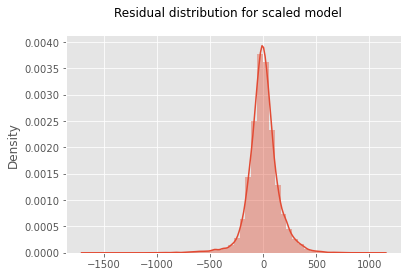

(None,
 Text(0.5, 0.98, 'Residual distribution for scaled model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [161]:
get_OLS_model('scaled',scaledX, y_sqrt)

In [162]:
get_vifs(scaledX)

                 Variable         VIF
0               bathrooms    2.821152
1                sqft_lot    1.203865
2                  floors    2.095425
3               condition    1.265329
4                   grade    2.695549
5              sqft_above    7.936066
6           sqft_basement    2.952938
7             sqft_garage    1.942777
8              sqft_patio    1.258357
9                yr_built    2.771267
10           yr_renovated    1.158071
11                    lat    1.475757
12                   long    1.583765
13          school_rating    1.318808
14                  month  117.641746
15            day_of_year  117.630036
16           sewer_PUBLIC    1.408264
17        heat_source_Gas    1.234423
18  heat_source_Gas/Solar    1.012082
19             waterfront    1.189211
20               nuisance    1.055506
21                   view    1.287633
22              greenbelt    1.045362
23        sqft_living_log    8.320085


### Adding waterfront dummies to the model

In [163]:
water_data = pd.concat([scaledX,waterfront_dummies], axis=1)

In [164]:
water_data.columns

Index(['bathrooms', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'school_rating', 'month', 'day_of_year',
       'sewer_PUBLIC', 'heat_source_Gas', 'heat_source_Gas/Solar',
       'waterfront', 'nuisance', 'view', 'greenbelt', 'sqft_living_log',
       'water_Elliot Bay', 'water_Lake Sammamish', 'water_Lake Washington',
       'water_Puget Sound', 'water_other'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1739.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:35:13   Log-Likelihood:            -1.7881e+05
No. Observations:               28004   AIC:                         3.577e+05
Df Residuals:                   27974   BIC:                         3.579e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   976.68

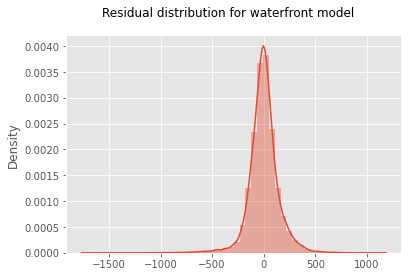

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [165]:
get_OLS_model('waterfront',water_data,y_sqrt)

Elliot Bay and Puget Sound present high pvalues indicating a lack of statistical significance. These will be dropped from the model. 

In [166]:
water_data = water_data.drop(['water_other'], axis=1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1800.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:35:26   Log-Likelihood:            -1.7881e+05
No. Observations:               28004   AIC:                         3.577e+05
Df Residuals:                   27975   BIC:                         3.579e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   963.11

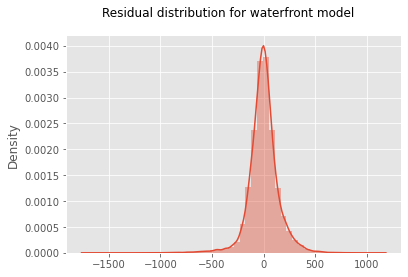

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [167]:
get_OLS_model('waterfront',water_data,y_sqrt)

## Recheck VIFs

In [168]:
get_vifs(water_data)

                 Variable         VIF
0               bathrooms    2.822800
1                sqft_lot    1.208054
2                  floors    2.097623
3               condition    1.266312
4                   grade    2.725312
5              sqft_above    7.944928
6           sqft_basement    2.958500
7             sqft_garage    1.954332
8              sqft_patio    1.259752
9                yr_built    2.782233
10           yr_renovated    1.158737
11                    lat    1.594028
12                   long    1.678379
13          school_rating    1.391194
14                  month  117.653026
15            day_of_year  117.640224
16           sewer_PUBLIC    1.495934
17        heat_source_Gas    1.236235
18  heat_source_Gas/Solar    1.012365
19             waterfront    1.194632
20               nuisance    1.056843
21                   view    1.290019
22              greenbelt    1.046040
23        sqft_living_log    8.332512
24       water_Elliot Bay    1.045550
25   water_L

#### Month and day_of_year present with high variance inflation factors indicating possible collinearity. These will be dropped. 

In [169]:
water_data = water_data.drop(['month','day_of_year','sqft_living_log'], axis =1)

In [170]:
get_vifs(water_data)

                 Variable       VIF
0               bathrooms  2.613181
1                sqft_lot  1.206485
2                  floors  2.085134
3               condition  1.240220
4                   grade  2.686084
5              sqft_above  3.274387
6           sqft_basement  1.792147
7             sqft_garage  1.936027
8              sqft_patio  1.258711
9                yr_built  2.764872
10           yr_renovated  1.156089
11                    lat  1.590733
12                   long  1.671893
13          school_rating  1.390790
14           sewer_PUBLIC  1.495842
15        heat_source_Gas  1.227726
16  heat_source_Gas/Solar  1.012330
17             waterfront  1.194429
18               nuisance  1.056327
19                   view  1.289824
20              greenbelt  1.046010
21       water_Elliot Bay  1.045322
22   water_Lake Sammamish  1.182965
23  water_Lake Washington  1.161392
24      water_Puget Sound  1.054799


All VIFs are now below 3 aside from sqft_above, meaning the issue of collinearity is now for the most part solved. 

## Final model

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     1940.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:36:58   Log-Likelihood:            -1.7916e+05
No. Observations:               28004   AIC:                         3.584e+05
Df Residuals:                   27978   BIC:                         3.586e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   963.23

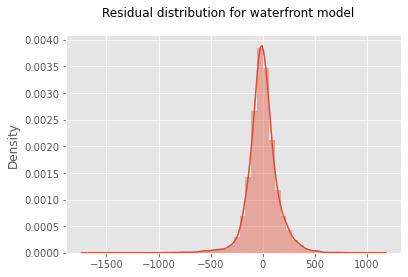

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [171]:
get_OLS_model('waterfront',water_data,y_sqrt)

In [172]:
water_data.columns

Index(['bathrooms', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'school_rating', 'sewer_PUBLIC',
       'heat_source_Gas', 'heat_source_Gas/Solar', 'waterfront', 'nuisance',
       'view', 'greenbelt', 'water_Elliot Bay', 'water_Lake Sammamish',
       'water_Lake Washington', 'water_Puget Sound'],
      dtype='object')

## Constructing QQplots for all independent variables within the model

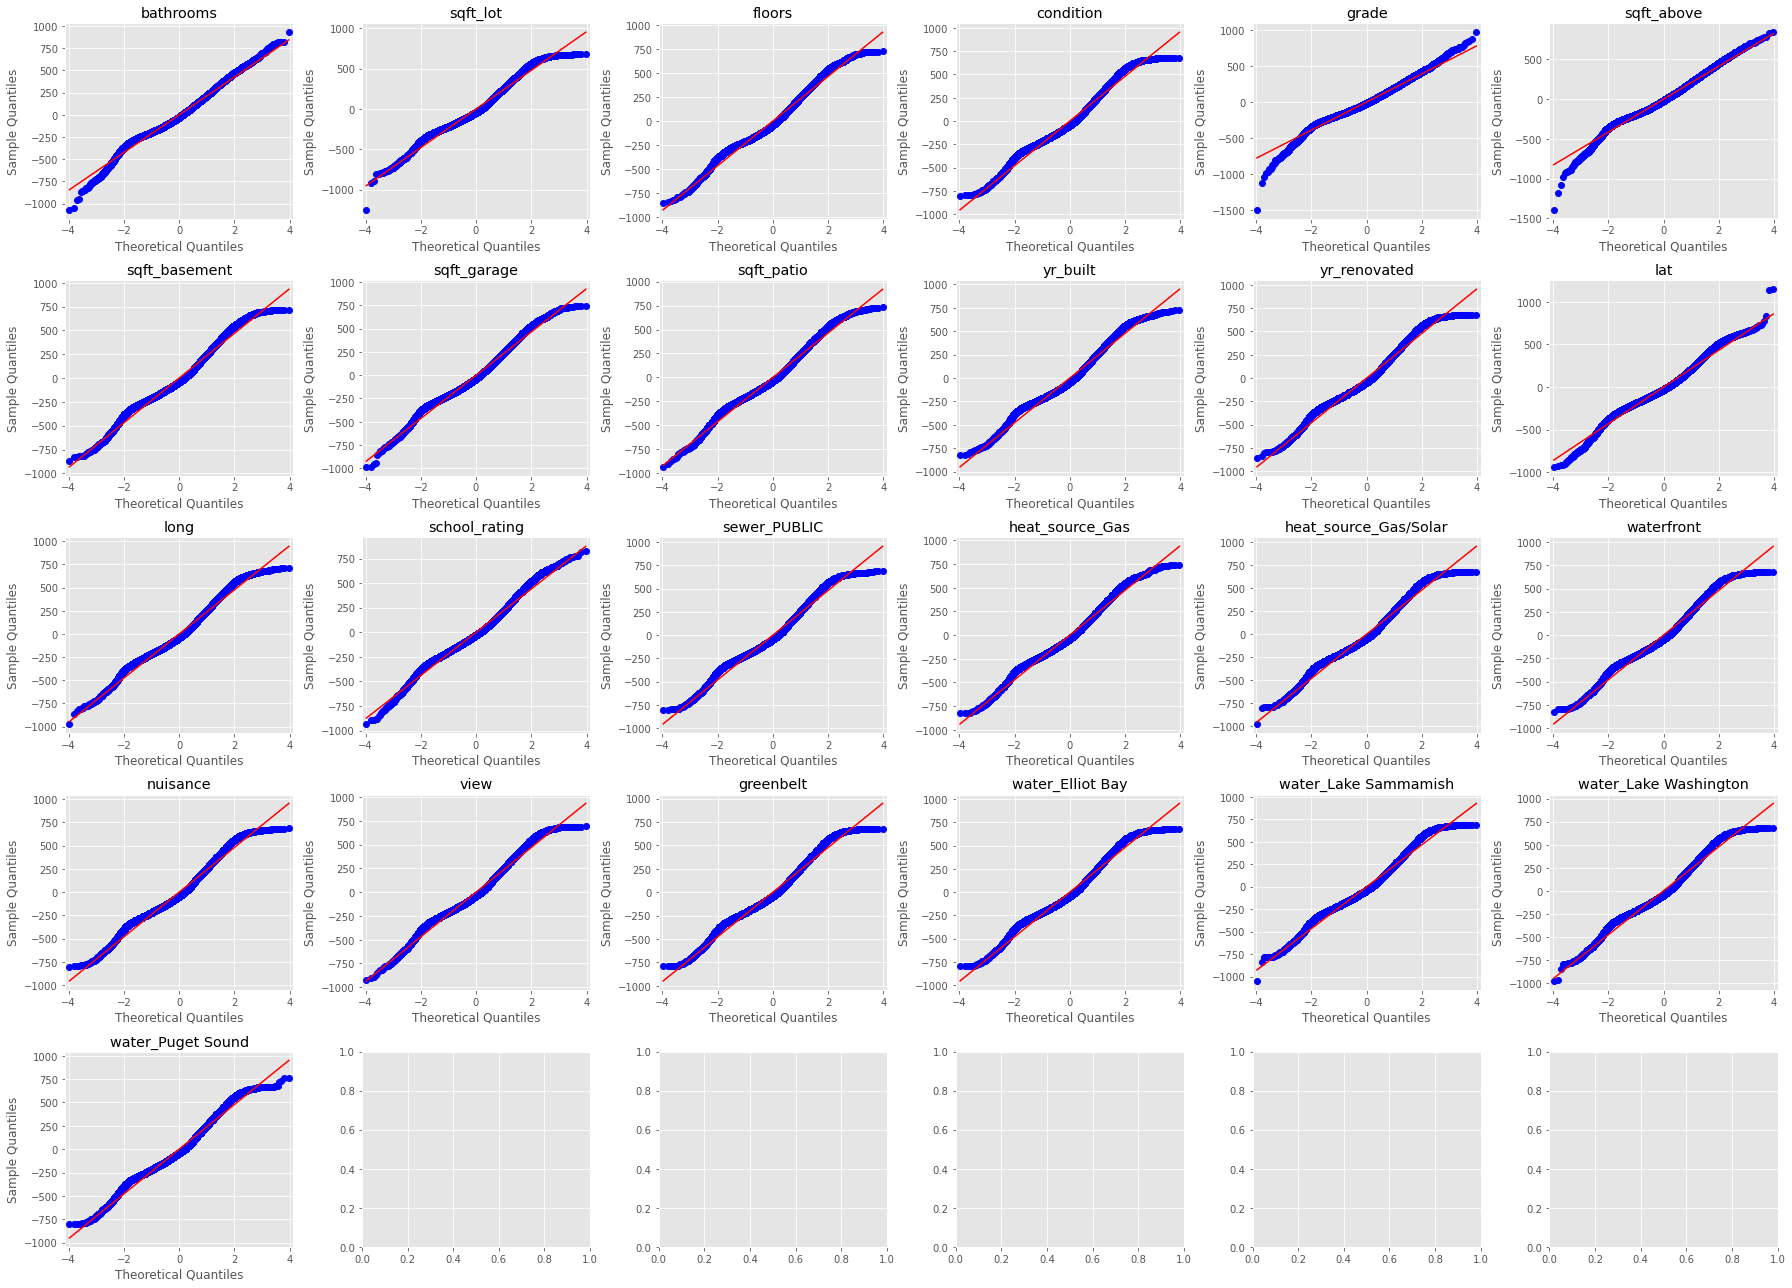

In [173]:
get_model_qqplots(water_data, y_sqrt)

In [174]:
model = sm.OLS(y_sqrt, sm.add_constant(water_data))
results = model.fit()
model_residual = results.resid
model_params = results.params

print(results.params)

const                    963.234796
bathrooms                 20.254186
sqft_lot                  10.414107
floors                    -7.052045
condition                 24.035449
grade                     68.459181
sqft_above                74.797094
sqft_basement             23.043827
sqft_garage               -4.584058
sqft_patio                 8.214320
yr_built                 -23.544185
yr_renovated               7.226726
lat                       88.816082
long                      11.343899
school_rating             27.353843
sewer_PUBLIC               6.584108
heat_source_Gas            9.278196
heat_source_Gas/Solar      3.607930
waterfront                 6.715330
nuisance                  -6.073275
view                      22.472439
greenbelt                  7.161059
water_Elliot Bay         -25.286029
water_Lake Sammamish      75.729413
water_Lake Washington    -64.398218
water_Puget Sound        -16.004882
dtype: float64


We have a linear model with the dependent variable (price) square root transformed, and the following independent variables and their corresponding coefficients:

- const: 963.234796
- bathrooms: 20.254186
- sqft_lot: 10.414107
- floors: -7.052045
- condition: 24.035449
- grade: 68.459181
- sqft_above: 74.797094
- sqft_basement: 23.043827
- sqft_garage: -4.584058
- sqft_patio: 8.214320
- yr_built: -23.544185
- yr_renovated: 7.226726
- lat: 88.816082
- long: 11.343899
- school_rating: 27.353843
- sewer_PUBLIC: 6.584108
- heat_source_Gas: 9.278196
- heat_source_Gas/Solar: 3.607930
- waterfront: 6.715330
- nuisance: -6.073275
- view: 22.472439
- greenbelt: 7.161059
- water_Elliot Bay: -25.286029
- water_Lake Sammamish: 75.729413
- water_Lake Washington: -64.398218
- water_Puget Sound: -16.004882


`A positive coefficient indicates that as the corresponding independent variable increases, the square root of the price of the house also increases, while a negative coefficient indicates that as the corresponding independent variable increases, the square root of the price of the house decreases.`

`In this model, we see that the most important variable in predicting the square root of house prices is the latitude of the house, with a coefficient of 100.368386. This suggests that houses located further north tend to have higher prices. The next most important variable is water proximity, with Water_Lake Sammamish variable having a very high coefficient of 75.729, suggesting that houses located near this lake tend to have much higher prices than other houses. On the other hand, the Water_Lake Washington variable has a negative coefficient, indicating that houses located near this lake tend to have lower prices than other houses.`

`Other important variables include the grade of the house, the square footage of the house above ground, and the condition of the house, all with coefficients greater than 20. The number of bathrooms, square footage of the basement, and the size of the view from the house are also important, with coefficients greater than 15.`

`On the other hand, variables such as the square footage of the garage and the presence of a nuisance nearby have negative coefficients, indicating that houses with larger garages or located near nuisances tend to have lower prices. The year the house was built and the longitude of the house also have negative coefficients, suggesting that older houses and houses located further west tend to have lower prices.`

`Overall, these results suggest that there are many factors that contribute to the price of a house, and that location, house size and quality, and the presence of nearby amenities all play important roles in determining the square root of house prices.`

The constant coefficient in a linear regression model represents the expected value of the dependent variable (in this case, the square root of the price) when all the independent variables are equal to zero. Therefore, as the constant coefficient is 963.234796, we would expect the square root of the price to be around 963 when all the independent variables are zero. However, it's important to note that in the context of the model, there may not be any real-world scenarios where all the independent variables are actually zero. The constant term is mainly used as a baseline reference point for the other predictors in the model.

- `As the number of bathrooms increases by one standard deviation, the square root price increases by 20.254186.`
- `As the size of the lot increases by one standard deviation, the square root price increases by 10.414107.`
- `As the number of floors increases by one standard deviation, the square root price decreases by 7.052045.`
- `As the condition of the house increases by one standard deviation, the square root price increases by 24.035449.`
- `As the grade of the house increases by one standard deviation, the square root price increases by 68.459181.`
- `As the size of the above ground living area increases by one standard deviation, the square root price increases by 74.797094.`
- `As the size of the basement living area increases by one standard deviation, the square root price increases by 23.043827.`
- `As the size of the garage increases by one standard deviation, the square root price decreases by 4.584058.`
- `As the size of the patio increases by one standard deviation, the square root price increases by 8.214320.`
- `As the age of the house (yr_built) increases by one standard deviation, the square root price decreases by 23.544185.`
- `As the year of renovation (yr_renovated) increases by one standard deviation, the square root price increases by 7.226726.`
- `As the latitude of the house increases by one standard deviation, the square root price increases by 88.816082.`
- `As the longitude of the house increases by one standard deviation, the square root price increases by 11.343899.`
- `As the school rating increases by one standard deviation, the square root price increases by 27.353843.`
- `As the house has a public sewer system (sewer_PUBLIC) instead of a private one, the square root price increases by 6.584108.`
- `As the heat source for the house switches from something other than gas to gas, the square root price increases by 9.278196.`
- `As the heat source for the house switches from something other than gas/solar to gas/solar, the square root price increases by 3.607930.`
- `As the house is on a waterfront property, the square root price increases by 6.715330.`
- `As the house experiences a nuisance (as defined by the model), the square root price decreases by 6.073275.`
- `As the view from the house improves by one standard deviation, the square root price increases by 22.472439.`
- `As the house is adjacent to a greenbelt, the square root price increases by 7.161059.`
- `As the house is located closer to Elliot Bay (in Seattle), the square root price decreases by 25.286029.`
- `As the house is located closer to Lake Sammamish, the square root price increases by 75.729413.`
- `As the house is located closer to Lake Washington, the square root price decreases by 64.398218.`
- `As the house is located closer to Puget Sound, the square root price decreases by 16.004882.`